# Assignment 5

# Data Preparation


### Needed imports


In [1]:
import pandas as pd
import os
# from datetime import datetime
# import re # regex support
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import json
from sklearn.cluster import MeanShift, estimate_bandwidth, Birch
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
import h2o
from h2o.estimators import H2ORandomForestEstimator
from sklearn.linear_model import LinearRegression

### Data gathering


In [2]:
data_pathname = os.path.join(os.getcwd(), "data")
results_pathname = os.path.join(os.getcwd(), "results")
filename_citibike = "2015-citibike_tripdata_combined.csv"
filename_citibike_sample = "2015-citibike_tripdata_combined_sample.csv"
filename_weather = "weather_data_nyc.csv"
encoding_type = "utf-8"

# Change this flag if you want to use the full data set (~1,7gb). Warning: This will change the runtime significantly
use_sample_data = True

In [3]:
df_citibike = pd.DataFrame()
if use_sample_data:
    df_citibike = pd.read_csv(os.path.join(
        data_pathname, filename_citibike_sample), encoding=encoding_type)
else:
    df_citibike = pd.read_csv(os.path.join(
        data_pathname, filename_citibike), encoding=encoding_type)

df_weather = pd.read_csv(os.path.join(
    data_pathname, filename_weather), encoding=encoding_type)


# ETL Citibike dataset


In [4]:
print(f"Citibike DataFrame length: {len(df_citibike)}")
print(f"Show first and last rows of Citibike:")
df_citibike.iloc[[1, -1]]

Citibike DataFrame length: 99380
Show first and last rows of Citibike:


Unnamed: 0  tripduration            starttime             stoptime  \
1         1043212          1542   4/13/2015 08:07:06   4/13/2015 08:32:48   
99379     8672150           418  11/14/2015 15:39:48  11/14/2015 15:46:46   

       start station id start station name  start station latitude  \
1                   545    E 23 St & 1 Ave               40.736502   
99379               317  E 6 St & Avenue B               40.724537   

       start station longitude  end station id           end station name  \
1                   -73.978095             415  Pearl St & Hanover Square   
99379               -73.981854             301          E 2 St & Avenue B   

       end station latitude  end station longitude  bikeid    usertype  \
1                 40.704718             -74.009260   19785  Subscriber   
99379             40.722174             -73.983688   19774  Subscriber   

       birth year  gender  
1          1957.0       1  
99379      1961.0       1

In [5]:
print("Citibike DataFrame data types per column (auto import):")
print(f"{df_citibike.dtypes}")

Citibike DataFrame data types per column (auto import):
Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                 float64
gender                       int64
dtype: object


### Renaming


In [6]:
#df_citibike.rename(columns={"Unnamed: 0": "uniqueid"}, inplace=True)


In [7]:
df_citibike.rename(columns={"Unnamed: 0": "uniqueid",
                            "start station id": "start_station_id",
                            "start station name": "start_station_name",
                            "start station latitude": "start_station_latitude",
                            "start station longitude": "start_station_longitude",
                            "end station id": "end_station_id",
                            "end station name": "end_station_name",
                            "end station latitude": "end_station_latitude",
                            "end station longitude": "end_station_longitude",
                            "birth year": "birth_year"}, inplace=True)


### Type Conversion


In [8]:
# Some timestamps are missing values for seconds
print("Convert column starttime and stoptime from object to datetime")
df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'], format="%m/%d/%Y %H:%M:%S", errors="coerce").fillna(
    pd.to_datetime(df_citibike['starttime'], format="%m/%d/%Y %H:%M", errors="coerce"))
df_citibike['stoptime'] = pd.to_datetime(df_citibike['stoptime'], format="%m/%d/%Y %H:%M:%S", errors="coerce").fillna(
    pd.to_datetime(df_citibike['stoptime'], format="%m/%d/%Y %H:%M", errors="coerce"))
print(
    f"Example after conversion: {df_citibike['stoptime'][42]} with type {df_citibike['stoptime'].dtype}")

Convert column starttime and stoptime from object to datetime
Example after conversion: 2015-06-30 17:59:00 with type datetime64[ns]


In [9]:
print("Checking for categorial values in the columns")
for column in df_citibike.columns:
    print(
        f"Column {column} has {df_citibike[column].value_counts().count()} distinct values")

Checking for categorial values in the columns
Column uniqueid has 99380 distinct values
Column tripduration has 4294 distinct values
Column starttime has 97028 distinct values
Column stoptime has 97046 distinct values
Column start_station_id has 485 distinct values
Column start_station_name has 494 distinct values
Column start_station_latitude has 507 distinct values
Column start_station_longitude has 507 distinct values
Column end_station_id has 488 distinct values
Column end_station_name has 497 distinct values
Column end_station_latitude has 510 distinct values
Column end_station_longitude has 510 distinct values
Column bikeid has 8348 distinct values
Column usertype has 2 distinct values
Column birth_year has 77 distinct values
Column gender has 3 distinct values


In [10]:
print("Convert to categorial variables")
df_citibike["start_station_id"] = df_citibike["start_station_id"].astype(
    "category")
df_citibike["end_station_id"] = df_citibike["end_station_id"].astype(
    "category")
df_citibike["usertype"] = df_citibike["usertype"].astype("category")
df_citibike["gender"] = df_citibike["gender"].replace(
    {0: "male", 1: "female", 2: "undefined"}).astype("category")

Convert to categorial variables


In [11]:
print("Convert birth_year to Integer")
df_citibike["birth_year"] = df_citibike["birth_year"].astype(
    "Int64")  # Int64Dtype can handle NaN values compared to int64

Convert birth_year to Integer


### Creating a date column


In [12]:
df_citibike["Date"] = pd.to_datetime(df_citibike["starttime"].dt.date)

### Detect and handle outliers


Check tripduration values for outliers


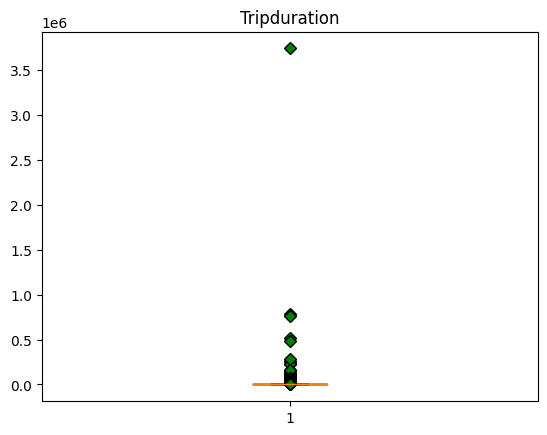

In [13]:
print("Check tripduration values for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Tripduration')
bp = ax1.boxplot(df_citibike['tripduration'], flierprops=green_diamond)
plt.show()

In [14]:
for key in bp:
    print(f'{key}: {[item.get_ydata() for item in bp[key]]}\n')

whiskers: [array([388.,  60.]), array([1050., 2043.])]

caps: [array([60, 60], dtype=int64), array([2043, 2043], dtype=int64)]

boxes: [array([ 388.,  388., 1050., 1050.,  388.])]

medians: [array([627., 627.])]

fliers: [array([6033, 2126, 2819, ..., 2630, 2199, 2175], dtype=int64)]

means: []



In [15]:
fliers = [item.get_ydata() for item in bp['fliers']]

q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]

lower_outliers = []
upper_outliers = []

for i in range(len(fliers)):
    lower_outliers_by_box = []
    upper_outliers_by_box = []
    for outlier in fliers[i]:
        if outlier < q1[i]:
            lower_outliers_by_box.append(round(outlier, 1))
        else:
            upper_outliers_by_box.append(round(outlier, 1))

    # storing outliers
    lower_outliers.append(lower_outliers_by_box)
    upper_outliers.append(upper_outliers_by_box)

print(f'Lower outliers: {len(lower_outliers_by_box)}\n'
      f'Upper outliers: {len(upper_outliers_by_box)}')

Lower outliers: 0
Upper outliers: 4803


Finding a resonable tripduration limit:


NYC Area = 789,4 km²


d=root(4A/π)


In [16]:
# NYC Area
import math
nycArea = 789.4  # km²
# we assume that 15km/h is the average speed
speed = 15
dOfNYC = math.sqrt(4*nycArea/math.pi)*2
maxduration_sec = (dOfNYC / speed ) * 3600
print(f"Diameter of NYC: {dOfNYC} km")
print(f"We assume an average speed of {speed} km/h")
print(f"We conclude that a trip should not be longer than: {maxduration_sec} seconds.")

Diameter of NYC: 63.40647590314218 km
We assume an average speed of 15 km/h
We conclude that a trip should not be longer than: 15217.554216754124 seconds.


In [17]:
column_name = 'tripduration'

column = df_citibike[column_name]

count = column[column > maxduration_sec].count()

print(f"{count}")

204


In [18]:
df_citibike_clean = df_citibike[df_citibike.tripduration <= maxduration_sec]

highest birth_year in raw data: 1999
lowest birth_year in raw data: 1885
We assume that users born before 1950 provided a false date


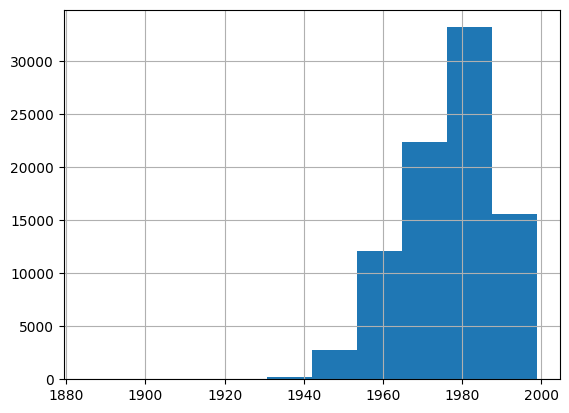

In [19]:
# check age of users
print(f"highest birth_year in raw data: {df_citibike.birth_year.max()}")
print(f"lowest birth_year in raw data: {df_citibike.birth_year.min()}")
df_citibike.birth_year.hist()
print(f"We assume that users born before 1950 provided a false date")

In [20]:
# replace birth_year < 1950 with NaN
df_citibike_clean.birth_year[df_citibike_clean.birth_year < 1950] = np.nan


C:\Users\relentne\AppData\Local\Temp\ipykernel_1464\3381151061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_citibike_clean.birth_year[df_citibike_clean.birth_year < 1950] = np.nan
C:\Users\relentne\AppData\Local\Temp\ipykernel_1464\3381151061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_citibike_clean.birth_year[df_citibike_clean.birth_year < 1950] = np.nan


highest birth_year in cleaned data: 1999
lowest birth_year in cleaned data: 1950


<AxesSubplot: >

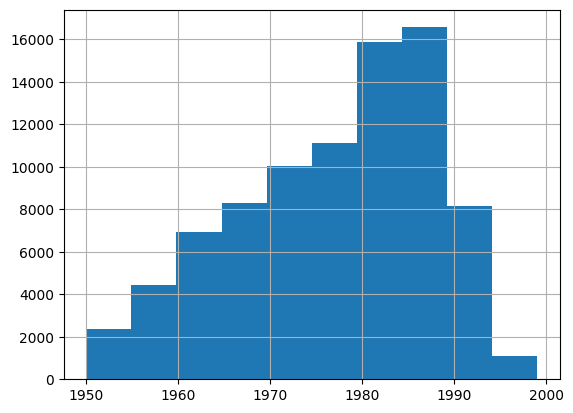

In [21]:
# check age of users (cleaned data)
print(f"highest birth_year in cleaned data: {df_citibike_clean.birth_year.max()}")
print(f"lowest birth_year in cleaned data: {df_citibike_clean.birth_year.min()}")
df_citibike_clean.birth_year.hist()

New Chart after Outlyers have been handled


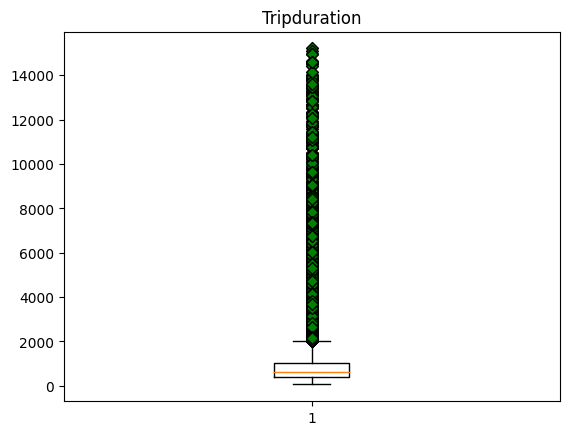

In [22]:
print("New Chart after Outlyers have been handled")
green_diamond = dict(markerfacecolor='g', marker='D')
fig2, ax2 = plt.subplots()
ax2.set_title('Tripduration')
bp = ax2.boxplot(df_citibike_clean['tripduration'], flierprops=green_diamond)
plt.show()

### Final Checks


In [23]:
print("Check for missing values in Citibike:")
df_citibike_clean.isna().sum()

Check for missing values in Citibike:


uniqueid                       0
tripduration                   0
starttime                      0
stoptime                       0
start_station_id               0
start_station_name             0
start_station_latitude         0
start_station_longitude        0
end_station_id                 0
end_station_name               0
end_station_latitude           0
end_station_longitude          0
bikeid                         0
usertype                       0
birth_year                 14291
gender                         0
Date                           0
dtype: int64

Since there are only values missing in the birth year, we decided to keep them in and use a later learned ml algorithm to try to guess the age (knn or other techniques)


In [24]:
print("Final Citibike DataFrame data types per column:")
print(f"{df_citibike_clean.dtypes}")

Final Citibike DataFrame data types per column:
uniqueid                            int64
tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                 category
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                   category
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                         category
birth_year                          Int64
gender                           category
Date                       datetime64[ns]
dtype: object


In [25]:
print("Final cleaned citibike dataset (first and last row):")
df_citibike_clean.iloc[[1, -1]]

Final cleaned citibike dataset (first and last row):


uniqueid  tripduration           starttime            stoptime  \
1       1043212          1542 2015-04-13 08:07:06 2015-04-13 08:32:48   
99379   8672150           418 2015-11-14 15:39:48 2015-11-14 15:46:46   

      start_station_id start_station_name  start_station_latitude  \
1                  545    E 23 St & 1 Ave               40.736502   
99379              317  E 6 St & Avenue B               40.724537   

       start_station_longitude end_station_id           end_station_name  \
1                   -73.978095            415  Pearl St & Hanover Square   
99379               -73.981854            301          E 2 St & Avenue B   

       end_station_latitude  end_station_longitude  bikeid    usertype  \
1                 40.704718             -74.009260   19785  Subscriber   
99379             40.722174             -73.983688   19774  Subscriber   

       birth_year  gender       Date  
1            1957  female 2015-04-13  
99379        1961  female 2015-11-14

# ETL Weather dataset


In [26]:
print("Show first and last row of weather dataset:")
df_weather.iloc[[1, -1]]

Show first and last row of weather dataset:


Unnamed: 0        Date  Max.TemperatureF  Mean.TemperatureF  \
1               2  1948-07-02                82               72.0   
24559       24627  2015-12-31                52               48.0   

       Min.TemperatureF  Max.Dew.PointF  MeanDew.PointF  Min.DewpointF  \
1                    63              62              53             49   
24559                43              46              38             27   

       Max.Humidity  Mean.Humidity  ...  Min.VisibilityMiles  \
1                76             51  ...                 10.0   
24559            93             71  ...                  5.0   

       Max.Wind.SpeedMPH  Mean.Wind.SpeedMPH  Max.Gust.SpeedMPH  \
1                     16                  10                NaN   
24559                 20                  12               25.0   

       PrecipitationIn  CloudCover  Events  WindDirDegrees.br...  \
1                 0.00         0.0     NaN             315<br />   
24559             0.06         7.0    Rain             317<br />   

                      city  season  
1      New York City (USA)  Summer  
24559  New York City (USA)  Winter  

[2 rows x 26 columns]

In [27]:
print("Weather DataFrame data types per column (auto import):")
print(f"{df_weather.dtypes}")

Weather DataFrame data types per column (auto import):
Unnamed: 0                     int64
Date                          object
Max.TemperatureF               int64
Mean.TemperatureF            float64
Min.TemperatureF               int64
Max.Dew.PointF                 int64
MeanDew.PointF                 int64
Min.DewpointF                  int64
Max.Humidity                   int64
Mean.Humidity                  int64
Min.Humidity                   int64
Max.Sea.Level.PressureIn     float64
Mean.Sea.Level.PressureIn    float64
Min.Sea.Level.PressureIn     float64
Max.VisibilityMiles          float64
Mean.VisibilityMiles         float64
Min.VisibilityMiles          float64
Max.Wind.SpeedMPH              int64
Mean.Wind.SpeedMPH             int64
Max.Gust.SpeedMPH            float64
PrecipitationIn               object
CloudCover                   float64
Events                        object
WindDirDegrees.br...          object
city                          object
season              

In [28]:
print("Rename columns to avoid whitespace and dot in the names")
df_weather.columns = df_weather.columns.str.replace(' ', '', regex=True)
df_weather.columns = df_weather.columns.str.replace('\.', '', regex=True)
df_weather.rename(columns={"Unnamed:0": "Id"}, inplace=True, errors="raise")

Rename columns to avoid whitespace and dot in the names


In [29]:
print("Convert column Date from object to datetime")
df_weather['Date'] = pd.to_datetime(df_weather['Date'], format='%Y-%m-%d')

Convert column Date from object to datetime


In [30]:
df_weather["Date"].iloc[[0, -1]]

0       1948-07-01
24559   2015-12-31
Name: Date, dtype: datetime64[ns]

In [31]:
print("Convert column PrecipitationIn from object to float")
df_weather['PrecipitationIn'] = pd.to_numeric(
    df_weather['PrecipitationIn'], errors='coerce')

Convert column PrecipitationIn from object to float


In [32]:
print("Convert column Events from object to string")
df_weather['Events'] = df_weather['Events'].astype('|S')
df_weather["Events"].iloc[[0, -1]]

Convert column Events from object to string


0         b'Fog'
24559    b'Rain'
Name: Events, dtype: bytes208

In [33]:
print("Show column WindDirDegreesbr (first and last rows)")
df_weather["WindDirDegreesbr"].iloc[[0, -1]]

Show column WindDirDegreesbr (first and last rows)


0        264<br />
24559    317<br />
Name: WindDirDegreesbr, dtype: object

In [34]:
print("Convert column WindDirDegreesbr from object to integer and remove the strings <br /> from each cell")

df_weather['WindDirectionDEG'] = df_weather['WindDirDegreesbr'].str.removesuffix(
    "<br />")
df_weather['WindDirectionDEG'] = df_weather['WindDirectionDEG'].astype('int')
df_weather["WindDirectionDEG"].iloc[[0, -1]]

Convert column WindDirDegreesbr from object to integer and remove the strings <br /> from each cell


0        264
24559    317
Name: WindDirectionDEG, dtype: int32

In [35]:
print("Converting Fahrenheit to Celsius")
def fahrenheit_to_celsius(fahrenheit):
    celsius = (fahrenheit - 32) * 5 / 9
    return celsius

df_weather["MaxTemperatureC"] = fahrenheit_to_celsius(
    df_weather["MaxTemperatureF"])
df_weather["MeanTemperatureC"] = fahrenheit_to_celsius(
    df_weather["MeanTemperatureF"])
df_weather["MinTemperatureC"] = fahrenheit_to_celsius(
    df_weather["MinTemperatureF"])
df_weather["MaxDewpointC"] = fahrenheit_to_celsius(
    df_weather["MaxDewPointF"])
df_weather["MeanDewpointC"] = fahrenheit_to_celsius(
    df_weather["MeanDewPointF"])
df_weather["MinDewpointC"] = fahrenheit_to_celsius(
    df_weather["MinDewpointF"])

print("Converting Miles to Kilometer")
def miles_to_km(miles):
    km = miles * 1.609344
    return km

df_weather["MinVisibilityKM"] = miles_to_km(df_weather["MinVisibilityMiles"])
df_weather["MaxVisibilityKM"] = miles_to_km(df_weather["MaxVisibilityMiles"])
df_weather["MeanVisibilityKM"] = miles_to_km(
    df_weather["MeanVisibilityMiles"])
df_weather["MaxWindSpeedKMH"] = miles_to_km(df_weather["MaxWindSpeedMPH"])
df_weather["MeanWindSpeedKMH"] = miles_to_km(
    df_weather["MeanWindSpeedMPH"])
df_weather["MaxGustSpeedKMH"] = miles_to_km(df_weather["MaxGustSpeedMPH"])

print("Converting inHg to hPa")
def inhg_to_hpa(inhg):
    hpa = inhg * 33.86389
    return hpa

df_weather["MaxSeaLevelPressureHPA"] = inhg_to_hpa(
    df_weather["MaxSeaLevelPressureIn"])
df_weather["MeanSeaLevelPressureHPA"] = inhg_to_hpa(
    df_weather["MeanSeaLevelPressureIn"])
df_weather["MinSeaLevelPressureHPA"] = inhg_to_hpa(
    df_weather["MinSeaLevelPressureIn"])

print("Converting CloudCover from eighths to percent")
def eighths_to_percent(eighths):
    percent = eighths / 8 * 100
    return percent

df_weather["CloudCoverPERCENT"] = eighths_to_percent(df_weather["CloudCover"])

print("Converting Inch to Millimeter")
def inch_to_mm(inch):
    mm = inch * 25.4
    return mm

df_weather["PrecipitationMM"] = inch_to_mm(
    df_weather["PrecipitationIn"].astype('float'))

Converting Fahrenheit to Celsius
Converting Miles to Kilometer
Converting inHg to hPa
Converting CloudCover from eighths to percent
Converting Inch to Millimeter


In [36]:
print("Drop not required columns after conversion")
df_weather.drop(['MaxTemperatureF', 'MeanTemperatureF', 'MinTemperatureF', 'MaxDewPointF', 'MeanDewPointF', 'MinDewpointF', 'MinVisibilityMiles', 'MaxVisibilityMiles', 'MeanVisibilityMiles', 'MaxWindSpeedMPH',
                'MeanWindSpeedMPH', 'MaxGustSpeedMPH', 'MaxSeaLevelPressureIn', 'MeanSeaLevelPressureIn', 'MinSeaLevelPressureIn', 'WindDirDegreesbr', 'PrecipitationIn', 'CloudCover'], axis=1, inplace=True)

Drop not required columns after conversion


In [37]:
#print("Rename columns to avoid whitespace and dot in the names")
#df_weather.columns = df_weather.columns.str.replace(' ', '', regex=True)
#df_weather.columns = df_weather.columns.str.replace('\.', '', regex=True)
#df_weather.rename(columns={"Unnamed:0": "Id"}, inplace=True, errors="raise")

In [38]:
print("Checking for categorial values in the columns")
for column in df_weather.columns:
    print(
        f"Column {column} has {df_weather[column].value_counts().count()} distinct values")

Checking for categorial values in the columns
Column Id has 24560 distinct values
Column Date has 24560 distinct values
Column MaxHumidity has 68 distinct values
Column MeanHumidity has 81 distinct values
Column MinHumidity has 91 distinct values
Column Events has 17 distinct values
Column city has 1 distinct values
Column season has 4 distinct values
Column WindDirectionDEG has 361 distinct values
Column MaxTemperatureC has 95 distinct values
Column MeanTemperatureC has 87 distinct values
Column MinTemperatureC has 82 distinct values
Column MaxDewpointC has 90 distinct values
Column MeanDewpointC has 93 distinct values
Column MinDewpointC has 99 distinct values
Column MinVisibilityKM has 13 distinct values
Column MaxVisibilityKM has 13 distinct values
Column MeanVisibilityKM has 21 distinct values
Column MaxWindSpeedKMH has 54 distinct values
Column MeanWindSpeedKMH has 38 distinct values
Column MaxGustSpeedKMH has 83 distinct values
Column MaxSeaLevelPressureHPA has 164 distinct valu

In [39]:
df_weather['season'].value_counts().count()

4

In [40]:
df_weather['season'].value_counts()

Summer    6364
Spring    6178
Autumn    6052
Winter    5966
Name: season, dtype: int64

In [41]:
df_weather['season'] = df_weather['season'].astype('category')

In [42]:
df_weather['Events'].value_counts().count()

17

In [43]:
df_weather['Events'].value_counts()
df_weather['Events'].dtypes

dtype('S26')

In [44]:
print("The most frequent events are rain and fog")

The most frequent events are rain and fog


In [45]:
df_weather['city'].value_counts()

New York City (USA)    24560
Name: city, dtype: int64

In [46]:
print("All locations are New York City")

All locations are New York City


In [47]:
df_weather['city'] = df_weather['city'].astype('category')

In [48]:
df_weather['CloudCoverPERCENT'].value_counts()

0.0      6738
100.0    2200
75.0     2195
87.5     2157
62.5     2132
50.0     1987
37.5     1755
25.0     1498
12.5     1117
Name: CloudCoverPERCENT, dtype: int64

Show distribution of Cloud Cover


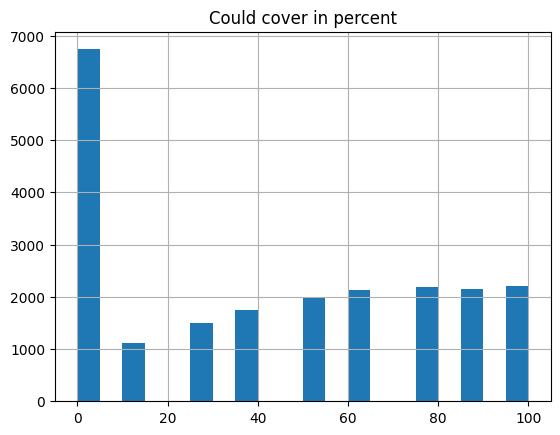

Most of the time it is a clear sky!


In [49]:
print("Show distribution of Cloud Cover")
plt.title('Could cover in percent')
df_weather['CloudCoverPERCENT'].hist(bins=20, range=[0, 100])
plt.show()
print("Most of the time it is a clear sky!")

In [50]:
df_weather['CloudCoverPERCENT'] = df_weather['CloudCoverPERCENT'].astype(
    'category')

Check temperature values for outliers


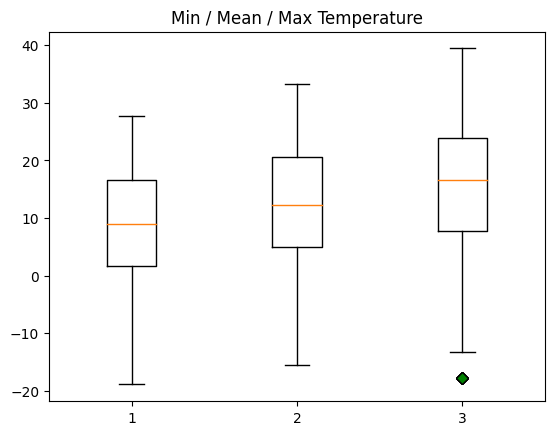

In [51]:
print("Check temperature values for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Min / Mean / Max Temperature')
ax1.boxplot([df_weather['MinTemperatureC'], df_weather['MeanTemperatureC'].dropna(
), df_weather['MaxTemperatureC']], flierprops=green_diamond)
plt.show()

Check visibility values for outliers


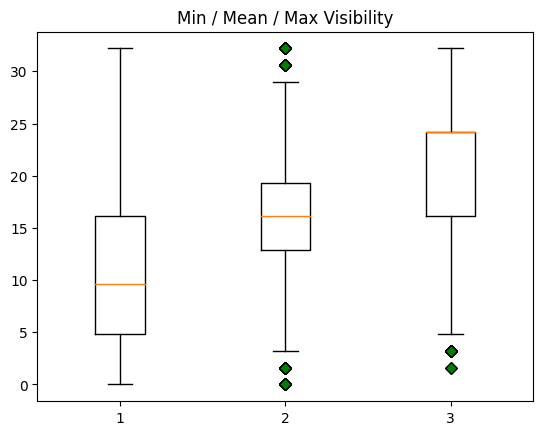

In [52]:
print("Check visibility values for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Min / Mean / Max Visibility')
ax1.boxplot([df_weather['MinVisibilityKM'].dropna(), df_weather['MeanVisibilityKM'].dropna(
), df_weather['MaxVisibilityKM'].dropna()], flierprops=green_diamond)
plt.show()

Check humidity values for outliers


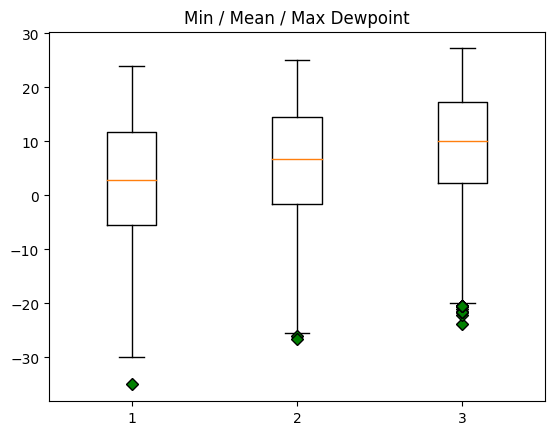

In [53]:
print("Check humidity values for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Min / Mean / Max Dewpoint')
ax1.boxplot([df_weather['MinDewpointC'], df_weather['MeanDewpointC'].dropna(
), df_weather['MaxDewpointC']], flierprops=green_diamond)
plt.show()

Check wind speed for outliers


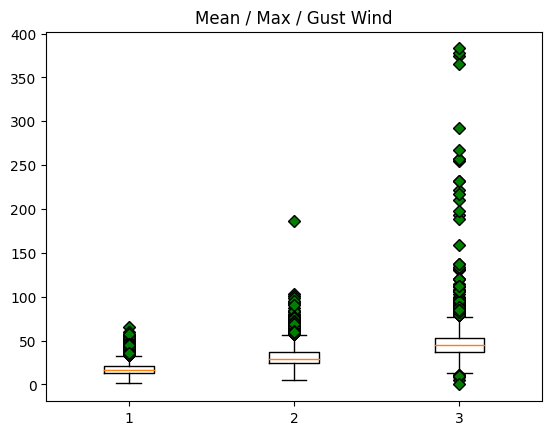

We see very high wind speeds (gusts) up to 375 km/h, which seems too high


In [54]:
print("Check wind speed for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Mean / Max / Gust Wind')
ax1.boxplot([df_weather['MeanWindSpeedKMH'].dropna(), df_weather['MaxWindSpeedKMH'].dropna(
), df_weather['MaxGustSpeedKMH'].dropna()], flierprops=green_diamond)
plt.show()
print("We see very high wind speeds (gusts) up to 375 km/h, which seems too high")

In [55]:
print("Show rows with MaxWind stronger than 100 km/h")
df_weather[df_weather.MaxWindSpeedKMH > 100]

Show rows with MaxWind stronger than 100 km/h


Id       Date  MaxHumidity  MeanHumidity  MinHumidity       Events  \
877      880 1950-11-25          100            89           76  b'Fog-Rain'   
9210    9236 1973-09-18           97            81           55  b'Fog-Rain'   
23910  23977 2014-03-22           76            49           22       b'nan'   

                      city  season  WindDirectionDEG  MaxTemperatureC  ...  \
877    New York City (USA)  Autumn               111        15.000000  ...   
9210   New York City (USA)  Summer               212        23.888889  ...   
23910  New York City (USA)  Spring               266        18.333333  ...   

       MaxVisibilityKM  MeanVisibilityKM  MaxWindSpeedKMH  MeanWindSpeedKMH  \
877           16.09344          9.656064       102.998016         65.983104   
9210          24.14016         14.484096       101.388672         22.530816   
23910         16.09344         16.093440       186.683904         22.530816   

       MaxGustSpeedKMH  MaxSeaLevelPressureHPA  MeanSeaLevelPressureHPA  \
877                NaN             1018.287172              1003.387061   
9210               NaN             1020.657645              1013.207589   
23910       292.900608             1017.948533              1012.530311   

       MinSeaLevelPressureHPA  CloudCoverPERCENT  PrecipitationMM  
877                990.180144                0.0              0.0  
9210              1008.805283               75.0             12.7  
23910             1008.128005               50.0              0.0  

[3 rows x 26 columns]

In [56]:
print("Show rows with GustWind stronger than 200 km/h")
df_weather[df_weather.MaxGustSpeedKMH > 200]

Show rows with GustWind stronger than 200 km/h


Id       Date  MaxHumidity  MeanHumidity  MinHumidity  \
21120  21179 2006-08-01           87            67           46   
21146  21205 2006-08-27           93            75           57   
21158  21217 2006-09-08           87            71           54   
21165  21224 2006-09-15           93            90           87   
21245  21304 2006-12-04           70            51           32   
21375  21435 2007-04-13           82            60           38   
21376  21436 2007-04-14           70            50           30   
21427  21487 2007-06-04           93            82           70   
21433  21493 2007-06-10           84            64           44   
21985  22046 2008-12-13           54            45           35   
22163  22225 2009-06-09           93            85           76   
23910  23977 2014-03-22           76            49           22   
23937  24004 2014-04-18           79            64           49   
24447  24515 2015-09-10           93            85           76   

                         Events                 city  season  \
21120                    b'nan'  New York City (USA)  Summer   
21146                   b'Rain'  New York City (USA)  Summer   
21158                    b'nan'  New York City (USA)  Summer   
21165      b'Rain-Thunderstorm'  New York City (USA)  Summer   
21245                    b'nan'  New York City (USA)  Autumn   
21375                    b'nan'  New York City (USA)  Spring   
21376                    b'nan'  New York City (USA)  Spring   
21427      b'Rain-Thunderstorm'  New York City (USA)  Spring   
21433                    b'nan'  New York City (USA)  Spring   
21985                    b'nan'  New York City (USA)  Autumn   
22163  b'Fog-Rain-Thunderstorm'  New York City (USA)  Spring   
23910                    b'nan'  New York City (USA)  Spring   
23937                    b'nan'  New York City (USA)  Spring   
24447      b'Rain-Thunderstorm'  New York City (USA)  Summer   

       WindDirectionDEG  MaxTemperatureC  ...  MaxVisibilityKM  \
21120               235        36.111111  ...         16.09344   
21146               128        23.333333  ...         16.09344   
21158               217        26.666667  ...         16.09344   
21165                49        20.000000  ...         16.09344   
21245               302         6.111111  ...         16.09344   
21375               283        11.111111  ...         16.09344   
21376               270        13.333333  ...         16.09344   
21427                 5        21.666667  ...         16.09344   
21433                52        22.777778  ...         16.09344   
21985               331         1.111111  ...         16.09344   
22163               124        21.111111  ...         16.09344   
23910               266        18.333333  ...         16.09344   
23937               113         7.777778  ...         16.09344   
24447                30        26.111111  ...         16.09344   

       MeanVisibilityKM  MaxWindSpeedKMH  MeanWindSpeedKMH  MaxGustSpeedKMH  \
21120         11.265408        35.405568         17.702784       254.276352   
21146         14.484096        37.014912         22.530816       374.977152   
21158         14.484096        28.968192         14.484096       231.745536   
21165         11.265408        41.842944         16.093440       257.495040   
21245         16.093440        46.670976         24.140160       378.195840   
21375         16.093440        56.327040         32.186880       210.824064   
21376         16.093440        41.842944         20.921472       257.495040   
21427          9.656064        45.061632         19.312128       383.023872   
21433         14.484096        19.312128          9.656064       222.089472   
21985         16.093440        41.842944         22.530816       267.151104   
22163         11.265408        32.186880         12.874752       365.321088   
23910         16.093440       186.683904         22.530816       292.900608   
23937         16.093440  

Check wind direction for outliers


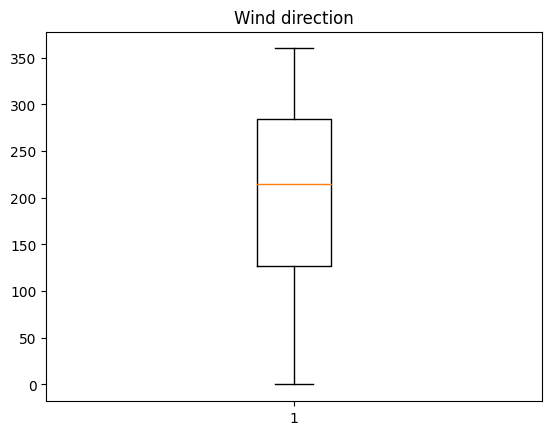

The predominant wind direction is 210° (wind from south-west)


In [57]:
print("Check wind direction for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Wind direction')
ax1.boxplot(df_weather['WindDirectionDEG'].dropna(), flierprops=green_diamond)
plt.show()
print("The predominant wind direction is 210° (wind from south-west)")

Show distribution of wind direction


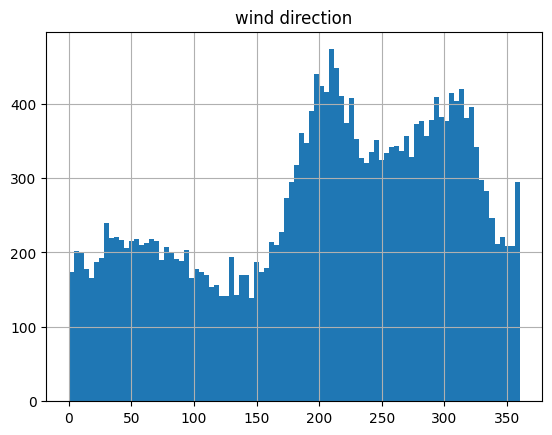

The predominant wind directions are between 200° and 320° (winds from south-west to north-west)


In [58]:
print("Show distribution of wind direction")
plt.title('wind direction')
df_weather['WindDirectionDEG'].hist(bins=90, range=[0, 360])
plt.show()
print("The predominant wind directions are between 200° and 320° (winds from south-west to north-west)")

In [59]:
print("Weather data types after cleaning, renaming and conversion:")
print(f"{df_weather.dtypes}")

Weather data types after cleaning, renaming and conversion:
Id                                  int64
Date                       datetime64[ns]
MaxHumidity                         int64
MeanHumidity                        int64
MinHumidity                         int64
Events                               |S26
city                             category
season                           category
WindDirectionDEG                    int32
MaxTemperatureC                   float64
MeanTemperatureC                  float64
MinTemperatureC                   float64
MaxDewpointC                      float64
MeanDewpointC                     float64
MinDewpointC                      float64
MinVisibilityKM                   float64
MaxVisibilityKM                   float64
MeanVisibilityKM                  float64
MaxWindSpeedKMH                   float64
MeanWindSpeedKMH                  float64
MaxGustSpeedKMH                   float64
MaxSeaLevelPressureHPA            float64
MeanSeaLevelPres

In [60]:
print("Check for missing values in Weather:")
df_weather.isna().sum()

Check for missing values in Weather:


Id                             0
Date                           0
MaxHumidity                    0
MeanHumidity                   0
MinHumidity                    0
Events                         0
city                           0
season                         0
WindDirectionDEG               0
MaxTemperatureC                0
MeanTemperatureC               2
MinTemperatureC                0
MaxDewpointC                   0
MeanDewpointC                  0
MinDewpointC                   0
MinVisibilityKM               15
MaxVisibilityKM               15
MeanVisibilityKM              15
MaxWindSpeedKMH                0
MeanWindSpeedKMH               0
MaxGustSpeedKMH            15538
MaxSeaLevelPressureHPA         0
MeanSeaLevelPressureHPA        0
MinSeaLevelPressureHPA         0
CloudCoverPERCENT           2781
PrecipitationMM              525
dtype: int64

In [61]:
print(f"Show first and last rows of Weather - after cleaning and conversion:")
df_weather.iloc[[0, -1]]

Show first and last rows of Weather - after cleaning and conversion:


Id       Date  MaxHumidity  MeanHumidity  MinHumidity   Events  \
0          1 1948-07-01           93            65           46   b'Fog'   
24559  24627 2015-12-31           93            71           49  b'Rain'   

                      city  season  WindDirectionDEG  MaxTemperatureC  ...  \
0      New York City (USA)  Summer               264        28.888889  ...   
24559  New York City (USA)  Winter               317        11.111111  ...   

       MaxVisibilityKM  MeanVisibilityKM  MaxWindSpeedKMH  MeanWindSpeedKMH  \
0             16.09344         11.265408        25.749504         12.874752   
24559         16.09344         16.093440        32.186880         19.312128   

       MaxGustSpeedKMH  MaxSeaLevelPressureHPA  MeanSeaLevelPressureHPA  \
0                  NaN             1018.287172              1016.255339   
24559          40.2336             1019.303089              1017.948533   

       MinSeaLevelPressureHPA  CloudCoverPERCENT  PrecipitationMM  
0                 1015.239422                0.0            0.000  
24559             1016.255339               87.5            1.524  

[2 rows x 26 columns]

# Joining the datasets


In [62]:
df_citibike_weather = pd.merge(
    df_citibike_clean, df_weather, how="left", on="Date")
df_citibike_weather.iloc[[1, -1]]

uniqueid  tripduration           starttime            stoptime  \
1       1043212          1542 2015-04-13 08:07:06 2015-04-13 08:32:48   
99175   8672150           418 2015-11-14 15:39:48 2015-11-14 15:46:46   

      start_station_id start_station_name  start_station_latitude  \
1                  545    E 23 St & 1 Ave               40.736502   
99175              317  E 6 St & Avenue B               40.724537   

       start_station_longitude end_station_id           end_station_name  ...  \
1                   -73.978095            415  Pearl St & Hanover Square  ...   
99175               -73.981854            301          E 2 St & Avenue B  ...   

       MaxVisibilityKM  MeanVisibilityKM  MaxWindSpeedKMH MeanWindSpeedKMH  \
1             16.09344          16.09344        46.670976        22.530816   
99175         16.09344          16.09344        46.670976        28.968192   

       MaxGustSpeedKMH MaxSeaLevelPressureHPA MeanSeaLevelPressureHPA  \
1            61.155072            1029.462256             1025.737228   
99175        61.155072            1025.398589             1018.287172   

       MinSeaLevelPressureHPA  CloudCoverPERCENT  PrecipitationMM  
1                 1022.350839               62.5              0.0  
99175             1011.175755               25.0              0.0  

[2 rows x 42 columns]

In [63]:
print(f"Rowcount of citibike dataset: {len(df_citibike_clean)} elements")
print(f"Rowcount of weather dataset: {len(df_weather)} elements")
print(f"Rowcount of joined dataset: {len(df_citibike_weather)} elements\n")

print(
    f"Columncount of citibike dataset: {len(df_citibike_clean.columns)} elements")
print(f"Columncount of weather dataset: {len(df_weather.columns)} elements")
print(
    f"Columncount of joined dataset: {len(df_citibike_weather.columns)} elements")


Rowcount of citibike dataset: 99176 elements
Rowcount of weather dataset: 24560 elements
Rowcount of joined dataset: 99176 elements

Columncount of citibike dataset: 17 elements
Columncount of weather dataset: 26 elements
Columncount of joined dataset: 42 elements


Everything seems fine with the joined dataframe. The Rowcount matches (since we did a left join) and the Columncount matches as well (17 + 26 = 43. Subtract one because of the duplicate Date column -> 42)


# Visualisation final dataset


In [64]:
pd.set_option("display.max_columns", None)

In [65]:
df_citibike_weather.iloc[[1, -1]]

uniqueid  tripduration           starttime            stoptime  \
1       1043212          1542 2015-04-13 08:07:06 2015-04-13 08:32:48   
99175   8672150           418 2015-11-14 15:39:48 2015-11-14 15:46:46   

      start_station_id start_station_name  start_station_latitude  \
1                  545    E 23 St & 1 Ave               40.736502   
99175              317  E 6 St & Avenue B               40.724537   

       start_station_longitude end_station_id           end_station_name  \
1                   -73.978095            415  Pearl St & Hanover Square   
99175               -73.981854            301          E 2 St & Avenue B   

       end_station_latitude  end_station_longitude  bikeid    usertype  \
1                 40.704718             -74.009260   19785  Subscriber   
99175             40.722174             -73.983688   19774  Subscriber   

       birth_year  gender       Date     Id  MaxHumidity  MeanHumidity  \
1            1957  female 2015-04-13  24365           83            65   
99175        1961  female 2015-11-14  24580           49            40   

       MinHumidity  Events                 city  season  WindDirectionDEG  \
1               47  b'nan'  New York City (USA)  Spring               185   
99175           30  b'nan'  New York City (USA)  Autumn               299   

       MaxTemperatureC  MeanTemperatureC  MinTemperatureC  MaxDewpointC  \
1            16.666667         11.666667         6.111111      7.777778   
99175        10.555556          8.333333         5.555556     -1.666667   

       MeanDewpointC  MinDewpointC  MinVisibilityKM  MaxVisibilityKM  \
1           4.444444      1.666667         16.09344         16.09344   
99175      -4.444444     -6.111111         16.09344         16.09344   

       MeanVisibilityKM  MaxWindSpeedKMH  MeanWindSpeedKMH  MaxGustSpeedKMH  \
1              16.09344        46.670976         22.530816        61.155072   
99175          16.09344        46.670976         28.968192        61.155072   

       MaxSeaLevelPressureHPA  MeanSeaLevelPressureHPA  \
1                 1029.462256              1025.737228   
99175             1025.398589              1018.287172   

       MinSeaLevelPressureHPA CloudCoverPERCENT  PrecipitationMM  
1                 1022.350839              62.5              0.0  
99175             1011.175755              25.0              0.0

In [66]:
print("Number of trips and mean trip duration per start station:")
df_t_s = df_citibike_weather.groupby(
    df_citibike_weather['start_station_id']).size().reset_index(name="nbtrips")
df_td_s = df_citibike_weather.groupby(df_citibike_weather['start_station_id'])[
    'tripduration'].mean().reset_index(name="tripduration")
df_t_td_s = pd.merge(df_t_s, df_td_s, how="inner", on="start_station_id")
df_t_td_s

Number of trips and mean trip duration per start station:


start_station_id  nbtrips  tripduration
0                 72      299   1010.113712
1                 79      213    936.596244
2                 82      107    870.401869
3                 83      110    959.636364
4                116      480    613.362500
..               ...      ...           ...
480             3234       68    779.382353
481             3235       59    639.169492
482             3236       52    691.807692
483             3237        2    713.000000
484             3238        2    926.000000

[485 rows x 3 columns]

In [67]:
# add new column starthour
df_citibike_weather['starthour'] = df_citibike_weather['starttime'].dt.hour
df_citibike_weather

uniqueid  tripduration           starttime            stoptime  \
0       2018212           146 2015-05-18 13:39:47 2015-05-18 13:42:14   
1       1043212          1542 2015-04-13 08:07:06 2015-04-13 08:32:48   
2       1435683          6033 2015-04-29 17:11:02 2015-04-29 18:51:35   
3       8250156          1414 2015-11-03 16:06:02 2015-11-03 16:29:37   
4       5393550           757 2015-08-25 17:30:52 2015-08-25 17:43:29   
...         ...           ...                 ...                 ...   
99171   1663859           720 2015-05-07 10:46:58 2015-05-07 10:58:58   
99172   6855750          1153 2015-09-29 08:47:37 2015-09-29 09:06:51   
99173   9311608          1098 2015-12-19 08:58:44 2015-12-19 09:17:02   
99174   4681928           438 2015-08-06 17:55:08 2015-08-06 18:02:26   
99175   8672150           418 2015-11-14 15:39:48 2015-11-14 15:46:46   

      start_station_id        start_station_name  start_station_latitude  \
0                  335  Washington Pl & Broadway               40.729039   
1                  545           E 23 St & 1 Ave               40.736502   
2                  466           W 25 St & 6 Ave               40.743954   
3                  401   Allen St & Rivington St               40.720196   
4                 2023   E 55 St & Lexington Ave               40.759681   
...                ...                       ...                     ...   
99171              496           E 16 St & 5 Ave               40.737262   
99172              400      Pitt St & Stanton St               40.719261   
99173              312   Allen St & E Houston St               40.722055   
99174              461           E 20 St & 2 Ave               40.735877   
99175              317         E 6 St & Avenue B               40.724537   

       start_station_longitude end_station_id           end_station_name  \
0                   -73.994046            439             E 4 St & 2 Ave   
1                   -73.978095            415  Pearl St & Hanover Square   
2                   -73.991449            466            W 25 St & 6 Ave   
3                   -73.989978            459           W 20 St & 11 Ave   
4                   -73.970314            533         Broadway & W 39 St   
...                        ...            ...                        ...   
99171               -73.992390            453            W 22 St & 8 Ave   
99172               -73.981780            466            W 25 St & 6 Ave   
99173               -73.989111            253            W 13 St & 5 Ave   
99174               -73.982050            402         Broadway & E 22 St   
99175               -73.981854            301          E 2 St & Avenue B   

       end_station_latitude  end_station_longitude  bikeid    usertype  \
0                 40.726281             -73.989780   15313  Subscriber   
1                 40.704718             -74.009260   19785  Subscriber   
2                 40.743954             -73.991449   19157  Subscriber   
3                 40.746745             -74.007756   18787  Subscriber   
4                 40.752996             -73.987216   14819  Subscriber   
...                     ...                    ...     ...         ...   
99171             40.744751             -73.999154   16620  Subscriber   
99172             40.743954             -73.991449   14665  Subscriber   
99173             40.735439             -73.994539   18690  Subscriber   
99174             40.740343             -73.989551   14539  Subscriber   
99175             40.722174             -73.983688   19774  Subscriber   

       birth_year     gender       Date     Id  MaxHumidity  MeanHumidity  \
0            1973     female 2015-05-18  24400           90            81   
1            1957     female 2015-04-13  24365           83            65   
2            1963     female 2015-04-29  24381           77            51   
3            1973     female 2015-11-03  24569           89            64   
4            1968     female 2

In [68]:
print("Tripduration per hour:")
df_td_h = df_citibike_weather.groupby('starthour')['tripduration'].mean().astype(int).sort_values(ascending=False).to_frame().reset_index()
df_td_h


Tripduration per hour:


starthour  tripduration
0          11           966
1          14           956
2          15           939
3          13           929
4          12           915
5          16           890
6           4           861
7          10           857
8          17           837
9          18           832
10         19           811
11         20           796
12         22           792
13          3           774
14         21           765
15         23           765
16          9           762
17          8           745
18          0           739
19          1           734
20          7           707
21          6           659
22          2           654
23          5           597

Shortest trips start at 5 AM


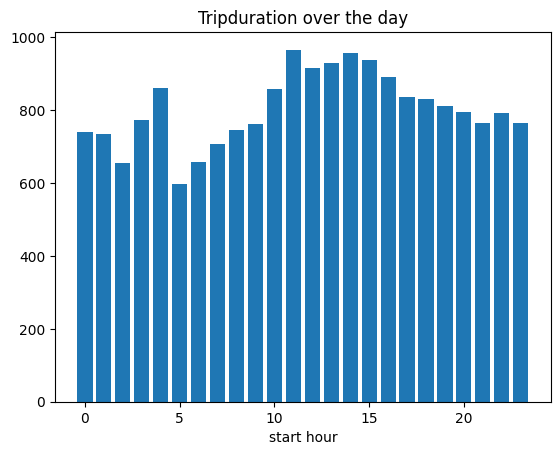

In [69]:
plt.title('Tripduration over the day')
plt.bar(df_td_h['starthour'], df_td_h['tripduration'])
plt.xlabel("start hour")
plt.show
print("Shortest trips start at 5 AM")

In [70]:
print("Mean triplength per station:")
df_td_s = df_citibike_weather.groupby('start_station_id')['tripduration'].mean(
).astype(int).sort_values(ascending=False).to_frame('tripduration').reset_index()
df_td_s

Mean triplength per station:


start_station_id  tripduration
0               3181          2542
1               2006          2248
2               3016          2032
3               3052          1873
4               3182          1764
..               ...           ...
480             3048           435
481             3114           426
482             3070           322
483             3059           246
484             3049           147

[485 rows x 2 columns]

The stations with id numbers 3xxx show the longest trip durations


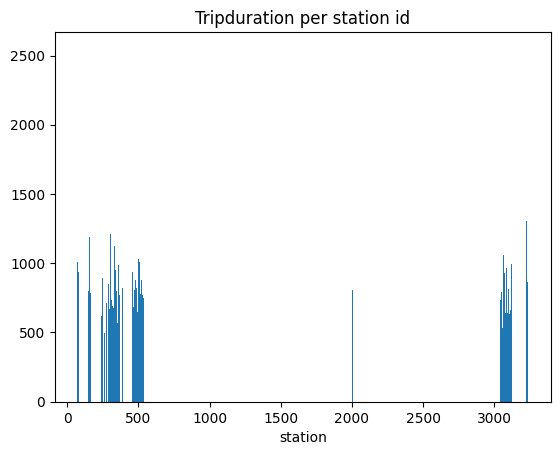

In [71]:
plt.title('Tripduration per station id')
plt.bar(df_td_s['start_station_id'], df_td_s['tripduration'])
plt.xlabel("station")
plt.show
print("The stations with id numbers 3xxx show the longest trip durations")

In [72]:
print("Mean triplength per weekday:")
# add column weekday
df_citibike_weather['weekday'] = df_citibike_weather['Date'].dt.day_name()
df_td_wd = df_citibike_weather.groupby('weekday')['tripduration'].mean().astype(
    int).sort_values(ascending=False).to_frame('tripduration').reset_index()
df_td_wd


Mean triplength per weekday:


weekday  tripduration
0     Sunday           986
1   Saturday           972
2     Friday           813
3     Monday           806
4   Thursday           792
5  Wednesday           783
6    Tuesday           771

Longest trips are on weekends


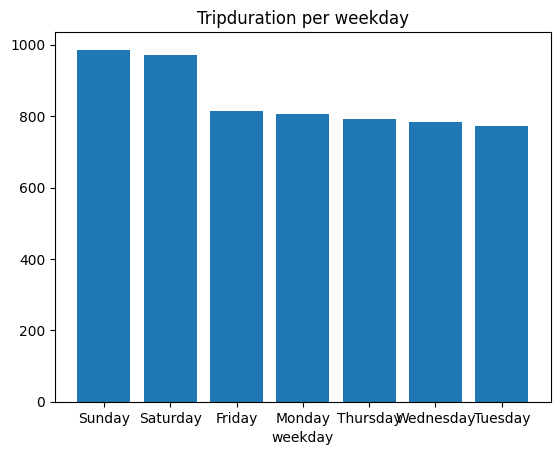

In [73]:
plt.title('Tripduration per weekday')
plt.bar(df_td_wd['weekday'], df_td_wd['tripduration'])
plt.xlabel("weekday")
plt.show
print("Longest trips are on weekends")

In [74]:
print("Total sum of trips per season:")
df_t_seas_sum = df_citibike_weather.groupby(
    'season')['Id'].size().sort_values(ascending=False).to_frame('trips').reset_index()
df_t_seas_sum

Total sum of trips per season:


season  trips
0  Summer  34963
1  Autumn  31867
2  Spring  23617
3  Winter   8729

During summer there are 4 times more trips compared to winter


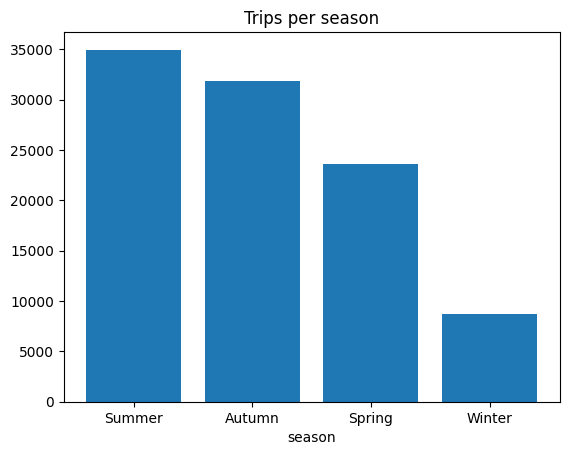

In [75]:
plt.title('Trips per season')
plt.bar(df_t_seas_sum['season'], df_t_seas_sum['trips'])
plt.xlabel("season")
plt.show
print("During summer there are 4 times more trips compared to winter")

In [76]:
print("Total sum of trips per weekday:")
df_t_wd_sum = df_citibike_weather.groupby(
    'weekday')['Id'].size().sort_values(ascending=True).to_frame('trips').reset_index()
df_t_wd_sum

Total sum of trips per weekday:


weekday  trips
0     Sunday  11472
1   Saturday  11675
2     Monday  14800
3   Thursday  15100
4    Tuesday  15112
5     Friday  15183
6  Wednesday  15834

Most trips are on Wednesdays


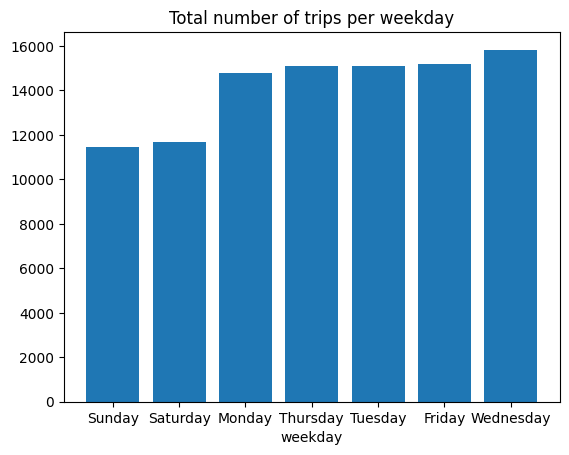

In [77]:
plt.title('Total number of trips per weekday')
plt.bar(df_t_wd_sum['weekday'], df_t_wd_sum['trips'])
plt.xlabel("weekday")
plt.show
print("Most trips are on Wednesdays")

In [78]:
px.scatter(df_citibike_weather, x="tripduration",
           y="MeanTemperatureC", color="season")

In [79]:
tmp = df_citibike_weather.groupby(["season", "gender"]).count().reset_index()
px.bar(tmp, x="season", y="uniqueid", color="gender", color_discrete_map={'female': '#f25e70',
                                                                          'male': '#73c0f0',
                                                                          'undefined': '#8ff296'})


In [80]:
fig_1 = make_subplots(rows=1, cols=2, specs=[
                      [{'type': 'domain'}, {'type': 'domain'}]])

labels = df_citibike_weather.loc[df_citibike_weather['season']
                                 == "Summer"]["gender"].value_counts().index
values = df_citibike_weather.loc[df_citibike_weather['season']
                                 == "Summer"]["gender"].value_counts().values
fig_1.add_trace(go.Pie(labels=labels, values=values), row=1, col=1)

labels = df_citibike_weather.loc[df_citibike_weather['season']
                                 == "Winter"]["gender"].value_counts().index
values = df_citibike_weather.loc[df_citibike_weather['season']
                                 == "Winter"]["gender"].value_counts().values
fig_1.add_trace(go.Pie(labels=labels, values=values), row=1, col=2)

fig_1.update_traces(hole=.4, hoverinfo="label+percent+name")
fig_1.update_traces(marker=dict(colors=['#f25e70', '#8ff296', '#73c0f0']))

fig_1.update_layout(
    title_text="Usage of Bikes per gender in Winter and Summer",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Summer', x=0.175, y=0.5, font_size=20, showarrow=False),
                 dict(text='Winter', x=0.82, y=0.5, font_size=20, showarrow=False)])

fig_1.show()


In [81]:
### Superseded by the next graph ###

df_citibike_weather_grouped = df_citibike_weather.groupby(
    ["birth_year", "season"]).count().reset_index()

# fig_2 = go.Figure(go.Heatmap(x = df_citibike_weather_grouped["season"], y = df_citibike_weather_grouped["birth_year"], z = df_citibike_weather_grouped["tripduration"], type = "heatmap", colorscale = "Blues"))
# # fig_2.update_yaxes(categoryorder="array", categoryarray=["<15" ,"15-20", "20-25", "25-30", "30-35", "35-40", "40-45", ">=45"][::-1])
# fig_2.update_layout(
#     title_text = 'Age Demographic per birth year and season',
# )
# fig_2.show()


In [82]:
fig_dropdown = go.Figure()
fig_dropdown.add_trace(go.Heatmap(x=df_citibike_weather_grouped["season"], y=df_citibike_weather_grouped[
                       "birth_year"], z=df_citibike_weather_grouped["tripduration"], type="heatmap", colorscale="Reds"))

# Add dropdowns
button_layer_1_height = 1.08
fig_dropdown.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=["colorscale", "Reds"],
                    label="Reds",
                    method="restyle"
                ),
                dict(
                    args=["colorscale", "Blues"],
                    label="Blues",
                    method="restyle"
                ),
                dict(
                    args=["colorscale", "Viridis"],
                    label="Viridis",
                    method="restyle"
                ),
                dict(
                    args=["colorscale", "Cividis"],
                    label="Cividis",
                    method="restyle"
                ),
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
        dict(
            buttons=list([
                dict(
                    args=["reversescale", False],
                    label="False",
                    method="restyle"
                ),
                dict(
                    args=["reversescale", True],
                    label="True",
                    method="restyle"
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.37,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
        dict(
            buttons=list([
                dict(
                    args=[{"type": "heatmap"}],
                    label="Heatmap",
                    method="restyle"
                ),
                dict(
                    args=[{"contours.showlines": False, "type": "contour"}],
                    label="Hide lines",
                    method="restyle"
                ),
                dict(
                    args=[{"contours.showlines": True, "type": "contour"}],
                    label="Show lines",
                    method="restyle"
                ),
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.58,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
    ]
)

# Update plot sizing
fig_dropdown.update_layout(
    width=1000,
    height=800,
    autosize=False,
    margin=dict(t=150, b=0, l=0, r=0),
)

fig_dropdown.update_layout(
    annotations=[
        dict(text="colorscale", x=0, xref="paper", y=1.06, yref="paper",
             align="left", showarrow=False),
        dict(text="Reverse<br>Colorscale", x=0.25, xref="paper", y=1.07,
             yref="paper", showarrow=False),
        dict(text="Lines", x=0.54, xref="paper", y=1.06, yref="paper",
             showarrow=False)
    ])

fig_dropdown.update_xaxes(categoryorder="array", categoryarray=[
                          "Spring", "Summer", "Autumn", "Winter"])
fig_dropdown.update_layout(
    title_text='Age Demographic per birth year and season',
)

fig_dropdown.show()


In [83]:
# read the neighborhood population data into a DataFrame and load the GeoJSON data
df_population = pd.read_csv(
    'data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')
df_population.iloc[[1, -1]]


Borough  Year  FIPS County Code NTA Code  \
1            Bronx  2000                 5     BX03   
389  Staten Island  2010                85     SI99   

                            NTA Name  Population  
1    Eastchester-Edenwald-Baychester       35422  
389  park-cemetery-etc-Staten Island           0

In [84]:
print("Rename columns to avoid whitespace in the names")
df_population.columns = df_population.columns.str.replace('\s', '', regex=True)
df_population.iloc[[1, -1]]


Rename columns to avoid whitespace in the names


Borough  Year  FIPSCountyCode NTACode  \
1            Bronx  2000               5    BX03   
389  Staten Island  2010              85    SI99   

                             NTAName  Population  
1    Eastchester-Edenwald-Baychester       35422  
389  park-cemetery-etc-Staten Island           0

In [85]:
# read the NYC neighborhoods GeoJSON data
nycmap = json.load(open("data/nyc_neighborhoods.geojson"))


# call Plotly Express choropleth function to visualize data
fig = px.choropleth_mapbox(df_population,
                           geojson=nycmap,
                           locations="NTACode",
                           featureidkey="properties.ntacode",
                           color="Population",
                           color_continuous_scale="viridis",
                           mapbox_style="carto-positron",
                           zoom=10, center={"lat": 40.75, "lon": -73.96},
                           opacity=0.5,
                           width=800,
                           hover_name="NTAName",
                           hover_data=["NTAName", "Population"]
                           )

for i in range(100):
    fig.add_trace(go.Scattermapbox(mode="markers+lines",
                                   lat=[df_citibike_weather.iloc[i]["start_station_latitude"],
                                        df_citibike_weather.iloc[i]["end_station_latitude"]],
                                   lon=[df_citibike_weather.iloc[i]["start_station_longitude"],
                                        df_citibike_weather.iloc[i]["end_station_longitude"]],
                                   marker={"size": 2}, line=dict(width=1)))

# fig.add_trace(go.Scattermapbox(mode="markers+lines", lat=[40.736502, 40.704718], lon=[-73.978095, -74.009260], marker = {"size": 2}))

fig.show()


# Supervised Learning

In [86]:
df_citibike_weather.iloc[[1, -1]]

uniqueid  tripduration           starttime            stoptime  \
1       1043212          1542 2015-04-13 08:07:06 2015-04-13 08:32:48   
99175   8672150           418 2015-11-14 15:39:48 2015-11-14 15:46:46   

      start_station_id start_station_name  start_station_latitude  \
1                  545    E 23 St & 1 Ave               40.736502   
99175              317  E 6 St & Avenue B               40.724537   

       start_station_longitude end_station_id           end_station_name  \
1                   -73.978095            415  Pearl St & Hanover Square   
99175               -73.981854            301          E 2 St & Avenue B   

       end_station_latitude  end_station_longitude  bikeid    usertype  \
1                 40.704718             -74.009260   19785  Subscriber   
99175             40.722174             -73.983688   19774  Subscriber   

       birth_year  gender       Date     Id  MaxHumidity  MeanHumidity  \
1            1957  female 2015-04-13  24365           83            65   
99175        1961  female 2015-11-14  24580           49            40   

       MinHumidity  Events                 city  season  WindDirectionDEG  \
1               47  b'nan'  New York City (USA)  Spring               185   
99175           30  b'nan'  New York City (USA)  Autumn               299   

       MaxTemperatureC  MeanTemperatureC  MinTemperatureC  MaxDewpointC  \
1            16.666667         11.666667         6.111111      7.777778   
99175        10.555556          8.333333         5.555556     -1.666667   

       MeanDewpointC  MinDewpointC  MinVisibilityKM  MaxVisibilityKM  \
1           4.444444      1.666667         16.09344         16.09344   
99175      -4.444444     -6.111111         16.09344         16.09344   

       MeanVisibilityKM  MaxWindSpeedKMH  MeanWindSpeedKMH  MaxGustSpeedKMH  \
1              16.09344        46.670976         22.530816        61.155072   
99175          16.09344        46.670976         28.968192        61.155072   

       MaxSeaLevelPressureHPA  MeanSeaLevelPressureHPA  \
1                 1029.462256              1025.737228   
99175             1025.398589              1018.287172   

       MinSeaLevelPressureHPA CloudCoverPERCENT  PrecipitationMM  starthour  \
1                 1022.350839              62.5              0.0          8   
99175             1011.175755              25.0              0.0         15   

        weekday  
1        Monday  
99175  Saturday

### Prediction the birth year of an unregistered user

In [87]:
# split the data set by birth_year included / excluded
# first remove all rows with NaN values
df_citibike_weather_user=df_citibike_weather[df_citibike_weather['birth_year'].notna()]
df_citibike_weather_nouser=df_citibike_weather[df_citibike_weather['birth_year'].isna()]
print(f"Number of total rows: {len(df_citibike_weather.index)}")
print(f"Number of rows with users birth_year: {len(df_citibike_weather_user.index)}")
print(f"Number of rows missing users birth_year: {len(df_citibike_weather_nouser.index)}")

Number of total rows: 99176
Number of rows with users birth_year: 84885
Number of rows missing users birth_year: 14291


In [88]:
# create train and test data sets from df_citikike_user
# Split data into train and testing
x = df_citibike_weather_user.drop(["birth_year", "uniqueid", "starttime", "stoptime", "Date", "start_station_name", "end_station_name", "bikeid", "usertype", "gender", "MaxHumidity", "MeanHumidity", "MinHumidity", "Events", "city", "season", "WindDirectionDEG", "MaxTemperatureC", "MeanTemperatureC", "MinTemperatureC", "MaxDewpointC", "MeanDewpointC", "MinDewpointC", "MinVisibilityKM", "MaxVisibilityKM", "MeanVisibilityKM", "MaxWindSpeedKMH", "MeanWindSpeedKMH", "MaxGustSpeedKMH", "MaxSeaLevelPressureHPA", "MeanSeaLevelPressureHPA", "MinSeaLevelPressureHPA", "CloudCoverPERCENT", "PrecipitationMM"], axis=1)
# convert categorial variable weekday into indicator variable
x = pd.get_dummies(x,prefix=['weekday'], columns = ['weekday'])
y = df_citibike_weather_user[['birth_year']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=420)

In [89]:
# use regression
regressor = LinearRegression()
#first parameter:input, second parameter:output
regressor.fit(x_train, y_train)

LinearRegression()

Text(0.5, 1.0, 'Fit on training set')

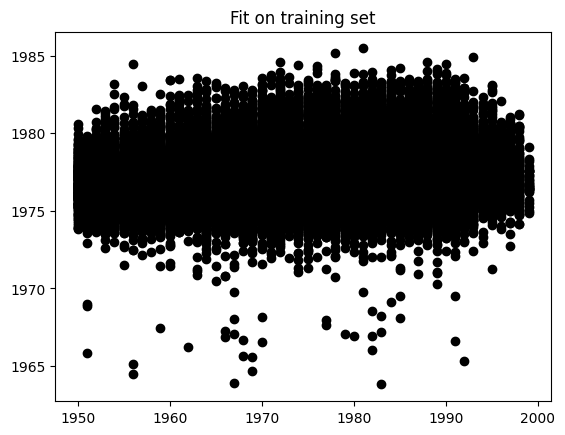

In [90]:
# Visualization
## Check the fitting on training set
plt.scatter(y_train, regressor.predict(x_train), color='black')
plt.title('Fit on training set')

In [91]:
#score: 
r_sq = regressor.score(x, y)
print(f"coefficient of determination: {r_sq}")

rmse = mean_squared_error(y_test, regressor.predict(x_test), squared=False)
print(f"RMSE: {rmse}")

coefficient of determination: 0.02050452016910076
RMSE: 10.797039648351479


In [92]:
# predict birth year
pred = regressor.predict(x_test)

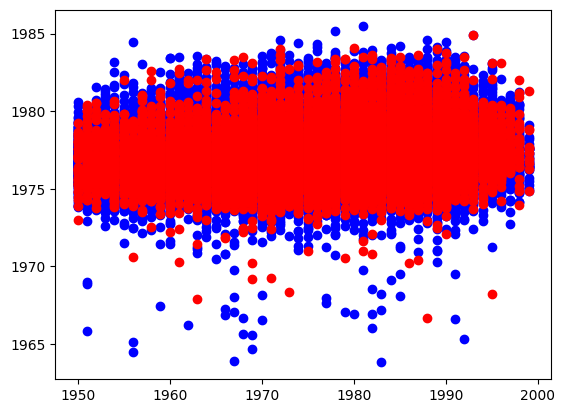

In [93]:
## Check fitting on validation set
plt.scatter(y_train, regressor.predict(x_train), color='b')
plt.scatter(y_test, pred, color='r')

In [94]:
print(f"{len(pred)} elements")
print(f"highest predicted birth_year: {pred.max()}")
print(f"lowest predicted birth_year: {pred.min()}")
print(f"highest birth_year in data: {df_citibike_weather_user.birth_year.max()}")
print(f"lowest birth_year in data: {df_citibike_weather_user.birth_year.min()}")

16977 elements
highest predicted birth_year: 1984.8976990685342
lowest predicted birth_year: 1966.6680415062883
highest birth_year in data: 1999
lowest birth_year in data: 1950


In [95]:
# use prediction on data set
df_input = df_citibike_weather.drop(["birth_year", "uniqueid", "starttime", "stoptime", "Date", "start_station_name", "end_station_name", "bikeid", "usertype", "gender", "MaxHumidity", "MeanHumidity", "MinHumidity", "Events", "city", "season", "WindDirectionDEG", "MaxTemperatureC", "MeanTemperatureC", "MinTemperatureC", "MaxDewpointC", "MeanDewpointC", "MinDewpointC", "MinVisibilityKM", "MaxVisibilityKM", "MeanVisibilityKM", "MaxWindSpeedKMH", "MeanWindSpeedKMH", "MaxGustSpeedKMH", "MaxSeaLevelPressureHPA", "MeanSeaLevelPressureHPA", "MinSeaLevelPressureHPA", "CloudCoverPERCENT", "PrecipitationMM"], axis=1)
# convert categorial variable weekday into indicator variable
df_input = pd.get_dummies(df_input,prefix=['weekday'], columns = ['weekday'])
df_input

tripduration start_station_id  start_station_latitude  \
0               146              335               40.729039   
1              1542              545               40.736502   
2              6033              466               40.743954   
3              1414              401               40.720196   
4               757             2023               40.759681   
...             ...              ...                     ...   
99171           720              496               40.737262   
99172          1153              400               40.719261   
99173          1098              312               40.722055   
99174           438              461               40.735877   
99175           418              317               40.724537   

       start_station_longitude end_station_id  end_station_latitude  \
0                   -73.994046            439             40.726281   
1                   -73.978095            415             40.704718   
2                   -73.991449            466             40.743954   
3                   -73.989978            459             40.746745   
4                   -73.970314            533             40.752996   
...                        ...            ...                   ...   
99171               -73.992390            453             40.744751   
99172               -73.981780            466             40.743954   
99173               -73.989111            253             40.735439   
99174               -73.982050            402             40.740343   
99175               -73.981854            301             40.722174   

       end_station_longitude     Id  starthour  weekday_Friday  \
0                 -73.989780  24400         13               0   
1                 -74.009260  24365          8               0   
2                 -73.991449  24381         17               0   
3                 -74.007756  24569         16               0   
4                 -73.987216  24499         17               0   
...                      ...    ...        ...             ...   
99171             -73.999154  24389         10               0   
99172             -73.991449  24534          8               0   
99173             -73.994539  24615          8               0   
99174             -73.989551  24480         17               0   
99175             -73.983688  24580         15               0   

       weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
0                   1                 0               0                 0   
1                   1                 0               0                 0   
2                   0                 0               0                 0   
3                   0                 0               0                 0   
4                   0                 0               0                 0   
...               ...               ...             ...               ...   
99171               0                 0               0                 1   
99172               0                 0               0                 0   
99173               0                 1               0                 0   
99174               0                 0               0                 1   
99175               0                 1               0                 0   

       weekday_Tuesday  weekday_Wednesday  
0                    0                  0  
1                    0                  0  
2                    0                  1  
3                    1                  0  
4                    1                  0  
...                ...                ...  
99171                0                  0  
99172                1                  0  
99173                0                  0  
99174                0                  0  
99175                0                  0  

[99176 rows x 16 columns]

In [96]:
df_citibike_weather['predicted_birth_year'] = regressor.predict(df_input)

In [97]:
# compare birth_year and predicted birth year
df_birth = df_citibike_weather[['birth_year', 'predicted_birth_year']]
df_birth = df_birth.dropna()
df_birth

birth_year  predicted_birth_year
0            1973           1977.214813
1            1957           1975.289400
2            1963           1971.243159
3            1973           1976.177238
4            1968           1976.699933
...           ...                   ...
99171        1959           1975.277353
99172        1982           1976.231948
99173        1993           1977.834982
99174        1965           1977.804102
99175        1961           1980.168506

[84885 rows x 2 columns]

Text(0, 0.5, 'predicted birth year')

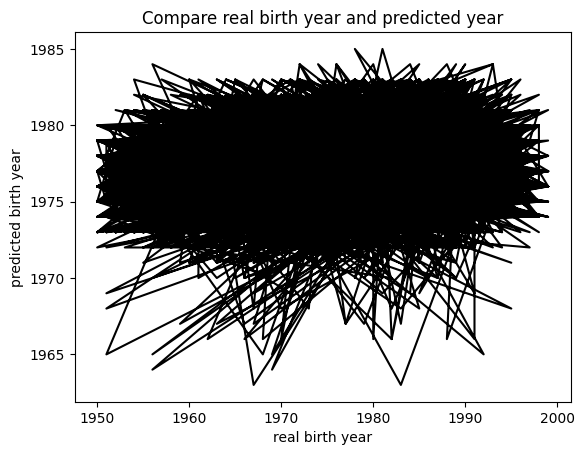

In [98]:
plt.plot(df_birth.birth_year, df_birth.predicted_birth_year.astype(int), color='black')
plt.title('Compare real birth year and predicted year')
plt.xlabel('real birth year')
plt.ylabel('predicted birth year')

In [99]:
print(f"The prediction does not work  :-(")

The prediction does not work  :-(


### (Vorschlag) Prediction on gender of undefined

In [100]:
df_citibike_weather['gender'].value_counts().reindex(['male','female','undefined'], fill_value=0)

male         13117
female       66068
undefined    19991
Name: gender, dtype: int64

In [101]:
# TODO: see description from previous chapter

### Prediction on number of trips

##### Preparation

In [102]:
df_number_trips = df_citibike_weather.groupby(["season", "weekday", "Events"])["uniqueid"].count().reset_index().rename({"uniqueid": "Number_of_trips"}, axis=1)
df_number_trips.head()

season weekday            Events  Number_of_trips
0  Autumn  Friday            b'Fog'             1050
1  Autumn  Friday       b'Fog-Rain'                0
2  Autumn  Friday  b'Fog-Rain-Snow'                0
3  Autumn  Friday       b'Fog-Snow'                0
4  Autumn  Friday           b'Rain'              405

##### Using standard regression

In [103]:
df_number_trips_enc = pd.get_dummies(df_number_trips,prefix=['season'], columns = ['season'])
df_number_trips_enc = pd.get_dummies(df_number_trips_enc,prefix=['weekday'], columns = ['weekday'])
df_number_trips_enc = pd.get_dummies(df_number_trips_enc,prefix=['Events'], columns = ['Events'])
# df_number_trips_enc = df_number_trips_enc.drop("Events", axis=1)

In [104]:
df_number_trips_enc.iloc[[1,-1]]

Number_of_trips  season_Autumn  season_Spring  season_Summer  \
1                  0              1              0              0   
251              571              0              0              0   

     season_Winter  weekday_Friday  weekday_Monday  weekday_Saturday  \
1                0               1               0                 0   
251              1               0               0                 0   

     weekday_Sunday  weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
1                 0                 0                0                  0   
251               0                 0                0                  1   

     Events_b'Fog'  Events_b'Fog-Rain'  Events_b'Fog-Rain-Snow'  \
1                0                   1                        0   
251              0                   0                        0   

     Events_b'Fog-Snow'  Events_b'Rain'  Events_b'Rain-Snow'  \
1                     0               0                    0   
251                   0               0                    0   

     Events_b'Rain-Thunderstorm'  Events_b'Snow'  Events_b'nan'  
1                              0               0              0  
251                            0               0              1

In [105]:
x = df_number_trips_enc.drop("Number_of_trips", axis=1)
y = df_number_trips_enc[["Number_of_trips"]]


In [106]:
# Split data into train and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=420)

In [107]:
regressor = LinearRegression()
#firt parameter:input, second parameter:output
regressor.fit(x_train, y_train)

LinearRegression()

In [108]:
pred = regressor.predict(x_test)

Text(0.5, 1.0, 'Fit on training set')

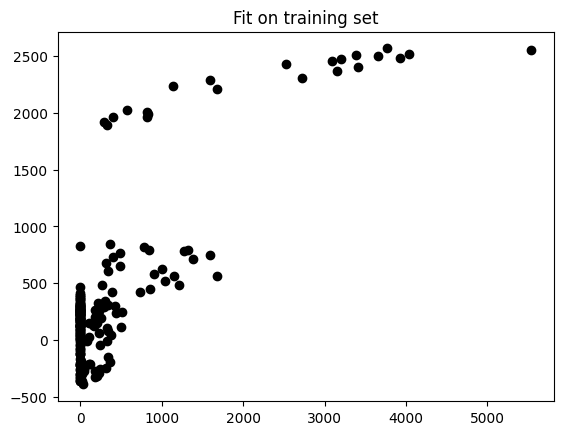

In [109]:
# Visualization
## Check the fitting on training set
plt.scatter(y_train, regressor.predict(x_train), color='black')
plt.title('Fit on training set')

In [110]:
#score: 
r_sq = regressor.score(x, y)
print(f"coefficient of determination: {r_sq}")

rmse = mean_squared_error(y_test, regressor.predict(x_test), squared=False)
print(f"RMSE: {rmse}")

coefficient of determination: 0.696347084811735
RMSE: 387.4441136170101


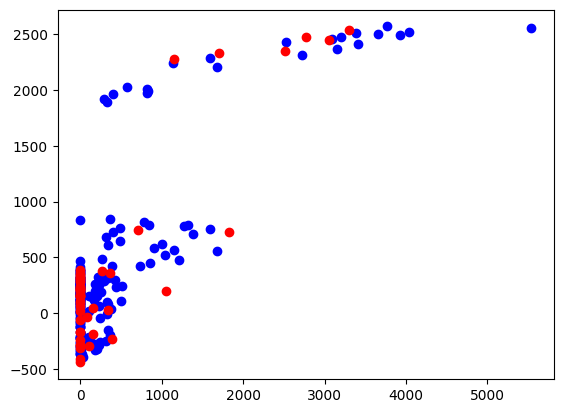

In [111]:
## Check fitting on validation set
plt.scatter(y_train, regressor.predict(x_train), color='b')
plt.scatter(y_test, pred, color='r')

##### Using h2o Random Forest

In [112]:
# Input parameters that are going to train
training_columns = ['season', 'weekday', 'Events']
# Output parameter train against input parameters
response_column = 'Number_of_trips'

# Split data into train and testing
train, test = train_test_split(df_number_trips, test_size=0.2, random_state=420)

In [113]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from C:\home\git_BDM\M3_BigData_MachineLearning\.conda\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\relentne\AppData\Local\Temp\tmp0hdhl1r1
  JVM stdout: C:\Users\relentne\AppData\Local\Temp\tmp0hdhl1r1\h2o_relentne_started_from_python.out
  JVM stderr: C:\Users\relentne\AppData\Local\Temp\tmp0hdhl1r1\h2o_relentne_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Europe/Berlin
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.3
H2O_cluster_version_age:    25 days
H2O_cluster_name:           H2O_from_python_relentne_5pmwe2
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.514 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.15 final
--------------------------  -------------------------------

In [114]:
h2o_train_data = h2o.H2OFrame(train)
h2o_test_data = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [115]:
# Define model
model1 = H2ORandomForestEstimator(ntrees=50, max_depth=10)
model2 = H2ORandomForestEstimator(ntrees=100, max_depth=50)
model3 = H2ORandomForestEstimator(ntrees=500, max_depth=100)

# Train model
model1.train(x=training_columns, y=response_column, training_frame=h2o_train_data)
model2.train(x=training_columns, y=response_column, training_frame=h2o_train_data)
model3.train(x=training_columns, y=response_column, training_frame=h2o_train_data)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1671379824908_3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    500                500                         207691                 2            13           8.432         4             48            28.302

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 213417.9833580411
RMSE: 461.97184260303254
MAE: 263.5045990408927
RMSLE: 3.771927289065996
Mean Residual Deviance: 213417.9833580411

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------
     2022-12-18 17:10:30  0.001 sec   0.0                nan                 nan                 nan
     2022-12-18 17:10:30  0.010 sec   1.0                486.7636793169498   267.98965948820114  236938.8795021743
     2022-12-18 17:10:30  0.012 sec   2.0                772.0650669947005   383.68794844945273  596084.4676735314
     2022-12-18 17:10:30  0.015 sec   3.0                624.6179312043437   330.22439326738055  390147.55998199416
     2022-12-18 17:10:30  0.017 sec   4.0                592.0722137114527   306.7962166782497   350549.5062491801
     2022-12-18 17:10:30  0.020 sec   5.0                525.7682261523711   298.6495812441576   276432.2276314109
     2022-12-18 17:10:30  0.025 sec   6.0                511.82938124408105  293.5839456735386   261969.31550469887
     2022-12-18 17:10:30  0.028 sec   7.0                543.4327946484469   314.64539312660906  295319.2022994211
     2022-12-18 17:10:30  0.030 sec   8.0                566.5399922200015   331.62735417303566  320967.5627846394
     2022-12-18 17:10:30  0.032 sec   9.0                567.1777995000791   331.4175820495143   321690.6562457519
---  ---                  ---         ---                ---                 ---                 ---
     2022-12-18 17:10:32  2.218 sec   491.0              461.70528540874454  263.124242801127    213171.77057437025
     2022-12-18 17:10:32  2.223 sec   492.0              461.7467125689711   263.1591140897974   213210.02656825198
     2022-12-18 17:10:32  2.227 sec   493.0              461.8467558943467   263.3347963747726   213302.42593013225
     2022-12-18 17:10:32  2.232 sec   494.0              461.6321056085116   263.1627303554127   213104.20092854803
     2022-12-18 17:10:32  2.236 sec   495.0              461.6088635482473   263.1819590681355   213082.74290630443
     2022-12-18 17:10:32  2.241 sec   496.0              461.94652531882605  263.2984411411369   213394.59225413678
     2022-12-18 17:10:32  2.246 sec   497.0              462.06355089253185  263.2002150936373   213502.72506341536
     2022-12-18 17:10:32  2.250 sec   498.0              462.3036472239572   263.65382197818576  213724.66223657312
     2022-12-18 17:10:32  2.256 sec   499.0              461.56919358592387  263.2359399562513   213046.12046756005
     2022-12-18 17:10:32  2.262 sec   500.0              461.97184260303254  263.5045990408927   213417.9833580411
[501 rows x 7 columns]


Variable Importances: 
variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
Events      3.52616e+10            1                    0.843638
season      4.44197e+09            0.125972             0.106275
weekday     2.0935e+09             0.0593705            0.0500872

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [116]:
# Model performance
performance1 = model1.model_performance(test_data=h2o_test_data)
performance2 = model2.model_performance(test_data=h2o_test_data)
performance3 = model3.model_performance(test_data=h2o_test_data)

print(performance1)
print(performance2)
print(performance3)

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 199172.57507594602
RMSE: 446.28754752507496
MAE: 286.1059937191477
RMSLE: 4.13143756671534
Mean Residual Deviance: 199172.57507594602
ModelMetricsRegression: drf
** Reported on test data. **

MSE: 183256.33120514837
RMSE: 428.0844907318512
MAE: 261.44145386314864
RMSLE: 4.044586539364137
Mean Residual Deviance: 183256.33120514837
ModelMetricsRegression: drf
** Reported on test data. **

MSE: 163434.47186550422
RMSE: 404.2702955517561
MAE: 252.5720402360267
RMSLE: 4.0339339920144655
Mean Residual Deviance: 163434.47186550422


##### Using NN

In [117]:
mlp = MLPRegressor(hidden_layer_sizes=(100,), random_state=420, max_iter=1000).fit(x_train, y_train)
mlp.predict(x_test)
rmse = mean_squared_error(y_test, mlp.predict(x_test), squared=False)
print(f"RMSE: {rmse}")

c:\home\git_BDM\M3_BigData_MachineLearning\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1593: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



RMSE: 816.2056191419634


c:\home\git_BDM\M3_BigData_MachineLearning\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



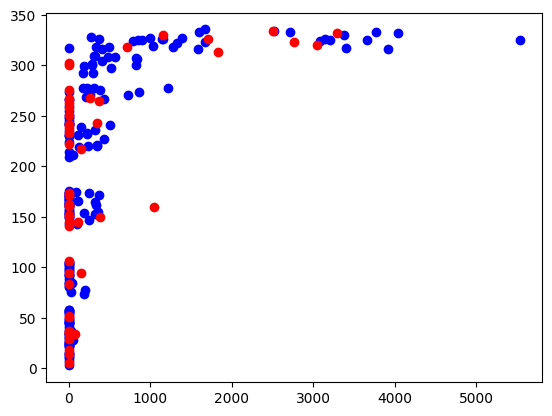

In [118]:
## Check fitting on validation set
plt.scatter(y_train, mlp.predict(x_train), color='b')
plt.scatter(y_test, mlp.predict(x_test), color='r')

Tuning the model

In [119]:
parameter_space = {
    'hidden_layer_sizes': [(100), (500), (1000), (1000, 500, 100), (1000, 100, 10), (1000, 10), (100, 10), (500, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [120]:
# clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
# clf.fit(x_train, y_train)

In [121]:
# # Best parameter set
# print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': 500, 'learning_rate': 'adaptive', 'solver': 'sgd'}

In [122]:
mlp = MLPRegressor(hidden_layer_sizes=(500,), activation="tanh", alpha=0.05, learning_rate="adaptive", solver="sgd", random_state=420, max_iter=1000).fit(x_train, y_train)
mlp.predict(x_test)
rmse = mean_squared_error(y_test, mlp.predict(x_test), squared=False)
print(f"RMSE: {rmse}")

c:\home\git_BDM\M3_BigData_MachineLearning\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1593: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



RMSE: 316.6766846211463


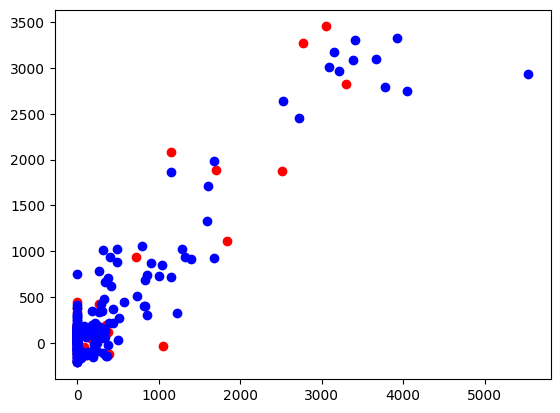

In [123]:
## Check fitting on validation set
plt.scatter(y_test, mlp.predict(x_test), color='r')
plt.scatter(y_train, mlp.predict(x_train), color='b')